## Preparation

In [0]:
# # TPU Setting
# import os
# assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'

# VERSION = "20200220"
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION


After pip install, need to restart the kernel.

In [1]:
!pip install numpy==1.16.4
!pip install pandas==0.25.0
!pip install torch==1.4.0
!pip install tqdm==4.43.0
!pip install scikit-plot

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

from collections import defaultdict
from collections import Counter

import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random

In [0]:
# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
import scikitplot as skplt

In [4]:
# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable

In [0]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

In [0]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [8]:
# Check Device
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [9]:
# Colab version
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Load data
file = open('drive/My Drive/Colab Data/train_speaker_df.pickle', 'rb')
df = pickle.load(file)

file.close()

print(df.shape)
df.head()

(675, 10)


,date,rate,speaker,target,text,type,word_count,target_lower,target_hold,target_raise
0,1994-02-04,3.25,Alan Greenspan,2,Chairman Alan Greenspan announced today that ...,statement,99,0,0,1
1,1994-03-22,3.5,Alan Greenspan,2,Chairman Alan Greenspan announced today that ...,statement,40,0,0,1
2,1994-04-18,3.75,Alan Greenspan,2,Chairman Alan Greenspan announced today that ...,statement,37,0,0,1
3,1994-05-17,4.25,Alan Greenspan,2,"In taking the discount action, the Board appr...",statement,57,0,0,1
4,1994-08-16,4.75,Alan Greenspan,2,"In taking the discount rate action, the Board...",statement,51,0,0,1


## Explore Data

1    390
2    147
0    138
Name: target, dtype: int64
1    0.577778
2    0.217778
0    0.204444
Name: target, dtype: float64


Text(0, 0.5, 'number of samples')

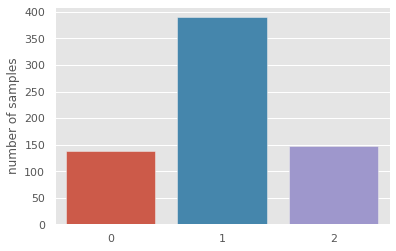

In [11]:
# The number of data per Target Labels
x = df.target.value_counts()
print(x)
print(x/sum(x))
sns.barplot(x.index, x)
plt.gca().set_ylabel('number of samples')

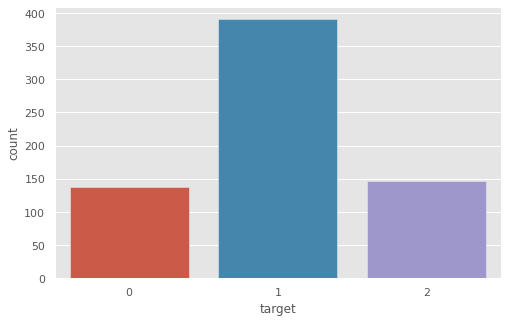

In [12]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='target', data=df)

The label is highly biased to 1(Hold). Need to consider how to mitigate the biased data.

In [0]:
# Corpus
def create_corpus(target):
    corpus = []
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

# Returns Top X frequent words
def get_frequent_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

Text(0.5, 1.0, 'Raise')

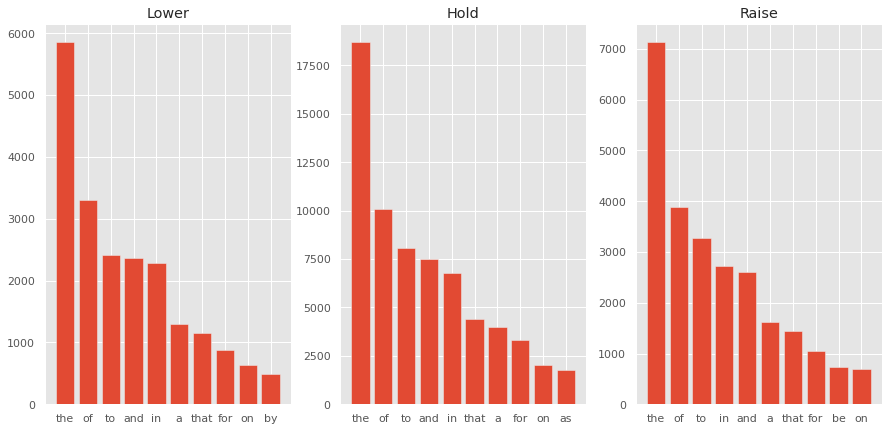

In [14]:
# Most frequent words
corpus_lower = create_corpus(0)
corpus_hold = create_corpus(1)
corpus_raise = create_corpus(2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
x, y = get_frequent_words(corpus_lower)
ax1.bar(x, y)
ax1.set_title('Lower')
x, y = get_frequent_words(corpus_hold)
ax2.bar(x, y)
ax2.set_title('Hold')
x, y = get_frequent_words(corpus_raise)
ax3.bar(x, y)
ax3.set_title('Raise')

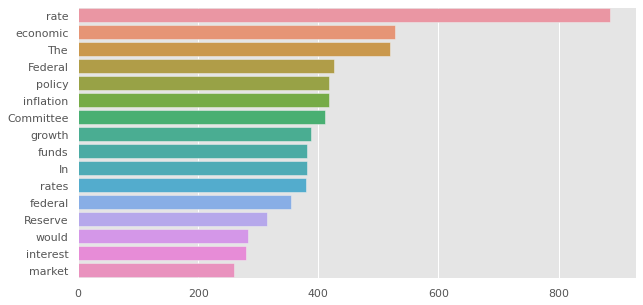

In [15]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus_lower)
most = counter.most_common()
x, y = [], []
for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(10,5))
sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Speech')

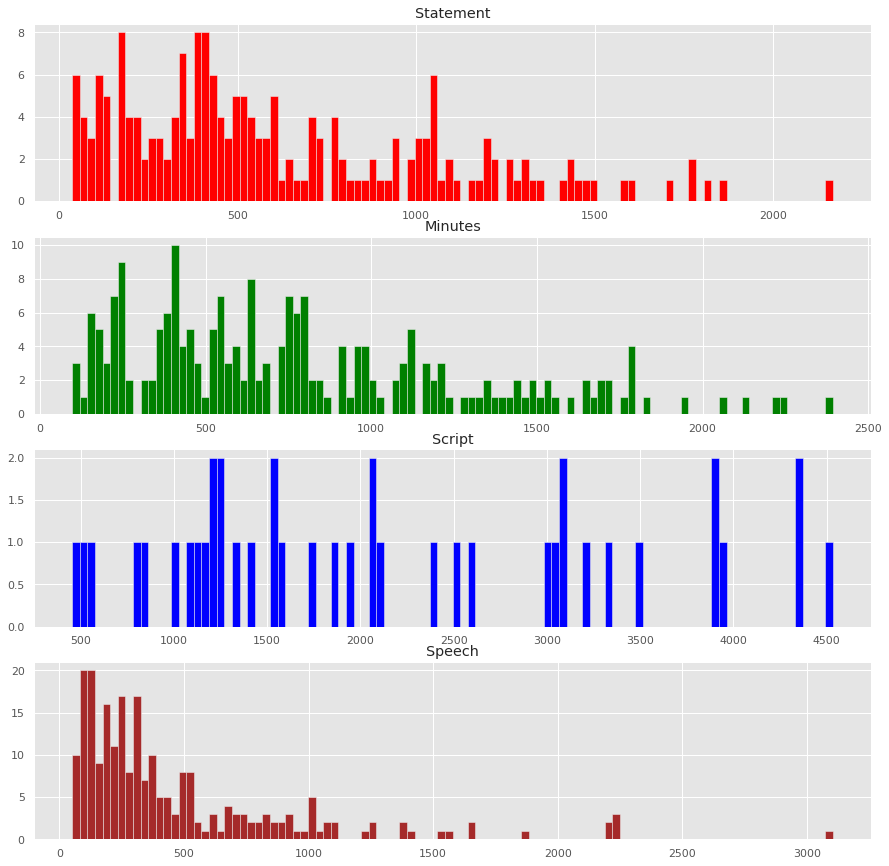

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15))
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
contents_len = df[df['type'] == 'statement']['word_count']
ax1.hist(contents_len, color='red', bins=100)
ax1.set_title('Statement')
contents_len = df[df['type'] == 'minutes']['word_count']
ax2.hist(contents_len, color='green', bins=100)
ax2.set_title('Minutes')
contents_len = df[df['type'] =='script']['word_count']
ax3.hist(contents_len, color='blue', bins=100)
ax3.set_title('Script')
contents_len = df[df['type'] =='speech']['word_count']
ax4.hist(contents_len, color='brown', bins=100)
ax4.set_title('Speech')


In [17]:
len(df[df['word_count'] > 300])

475

## Define Train DataFrame

In [18]:
#train_df = df # All data
train_df = df.loc[df['type'].isin(['statement'])]
#train_df = df.loc[df['type'].isin(['statement', 'minutes', 'script'])]
#train_df = df.loc[df['speaker']=='Ben Bernanke']

print(train_df.shape)
train_df.reset_index(inplace=True)
train_df['target'] = train_df['target'].apply(lambda x: int(x))
train_df

(192, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,index,date,rate,speaker,target,text,type,word_count,target_lower,target_hold,target_raise
0,0,1994-02-04,3.25,Alan Greenspan,2,Chairman Alan Greenspan announced today that ...,statement,99,0,0,1
1,1,1994-03-22,3.5,Alan Greenspan,2,Chairman Alan Greenspan announced today that ...,statement,40,0,0,1
2,2,1994-04-18,3.75,Alan Greenspan,2,Chairman Alan Greenspan announced today that ...,statement,37,0,0,1
3,3,1994-05-17,4.25,Alan Greenspan,2,"In taking the discount action, the Board appr...",statement,57,0,0,1
4,4,1994-08-16,4.75,Alan Greenspan,2,"In taking the discount rate action, the Board...",statement,51,0,0,1
5,5,1994-11-15,5.5,Alan Greenspan,2,"In a related move, the Federal Open Market Co...",statement,121,0,0,1
6,6,1995-02-01,6,Alan Greenspan,2,"In taking the discount action, the Board appr...",statement,54,0,0,1
7,7,1995-07-06,5.75,Alan Greenspan,0,Chairman Alan Greenspan announced today that ...,statement,67,1,0,0
8,8,1995-12-19,5.5,Alan Greenspan,0,Chairman Alan Greenspan announced today that ...,statement,81,1,0,0
9,9,1996-01-31,5.25,Alan Greenspan,0,For immediate releaseThe Federal Reserve toda...,statement,391,1,0,0


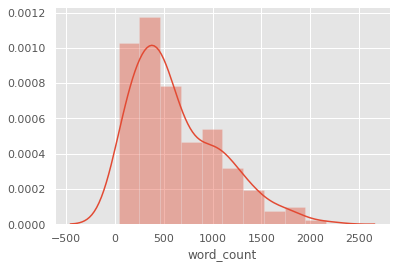

In [19]:
sns.distplot(train_df['word_count'])

In [0]:
# Define metrics
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

plt.rcParams["figure.figsize"] = (15,6)

## A. Tfidf + logistic regression

[2020-04-09 16:05:13,562][INFO] ## Training - acc: 0.84313725, f1: 0.80337691
[2020-04-09 16:05:13,565][INFO] ## Validationn - acc: 0.79487179, f1: 0.75396825


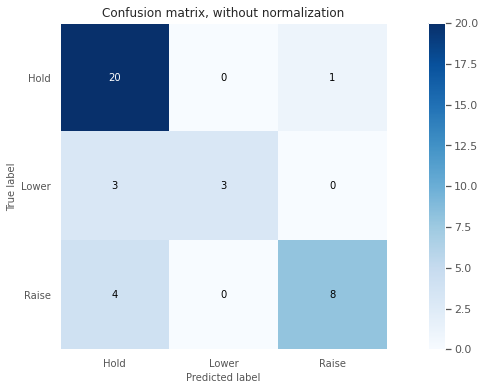

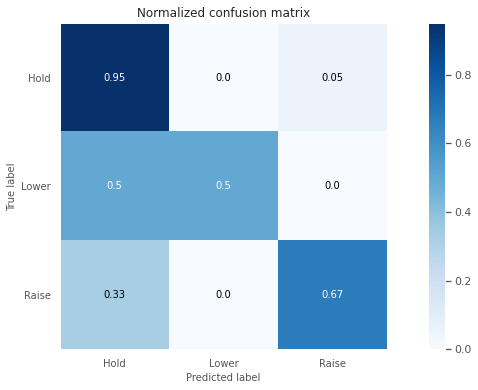

In [21]:
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def build_tfidf_logreg(df, validation=True):
    x_train = df['text']
    y_train = df['target']
    clf = Pipeline([
                    ('tfidf', TfidfVectorizer(analyzer='word')),
                    ('clf', LogisticRegression())
    ])

    if validation:
        x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train.values, y_train.values, test_size=0.2, random_state=42)
        clf.fit(x_train, y_train)
        predicted_train = clf.predict(x_train)
        predicted_valid = clf.predict(x_valid)

        acc, f1 = metric(y_train, predicted_train)
        logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
        acc, f1 = metric(y_valid, predicted_valid)
        logger.info('Validationn - acc: %.8f, f1: %.8f' % (acc, f1))

        # print("Training Accuracy: ", np.mean(predicted_train == y_train))
        # print("Validation Accuracy: ", np.mean(predicted_valid == y_valid))
    else:
        clf.fit(x_train, y_train)
        predicted_train = clf.predict(x_train)
        acc, f1 = metric(y_train, predicted_train)
        logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))

    class_names = ['Lower', 'Hold', 'Raise']
    y_valid_class = [class_names[idx] for idx in y_valid]
    predicted_valid_class = [class_names[idx] for idx in predicted_valid]
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
    plt.show()

    return clf

model = build_tfidf_logreg(train_df)

## B) RNN/LSTM

Extract words which are only aphabet and not in stop word, covert to lower case.

In [0]:
def tokenize_df(df):
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        tokens = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
        tokenized.append(tokens)
    return tokenized

In [23]:
tokenized = tokenize_df(train_df)

In [24]:
tokenized[0]

['chairman',
 'alan',
 'greenspan',
 'announce',
 'today',
 'federal',
 'open',
 'market',
 'committee',
 'decide',
 'increase',
 'slightly',
 'degree',
 'pressure',
 'reserve',
 'position',
 'the',
 'action',
 'expect',
 'associate',
 'small',
 'increase',
 'money',
 'market',
 'interest',
 'rate',
 'the',
 'decision',
 'take',
 'move',
 'toward',
 'le',
 'accommodative',
 'stance',
 'monetary',
 'policy',
 'order',
 'sustain',
 'enhance',
 'economic',
 'expansion',
 'chairman',
 'greenspan',
 'decide',
 'announce',
 'action',
 'immediately',
 'avoid',
 'misunderstand',
 'committee',
 'purpose',
 'give',
 'fact',
 'first',
 'firm',
 'reserve',
 'market',
 'condition',
 'committee',
 'since',
 'early']

In [25]:
from collections import Counter

print('len(tokenized): ', len(tokenized))
all_words = [word for text in tokenized for word in text]
#all_words = [word for word in text for text in tokenized]
#print(all_words[:20])
print('len(all_words): ', len(all_words))
counts = Counter(all_words)
print('len(counts): ', len(counts))
print('counts: ', counts)
bow = sorted(counts, key=counts.get, reverse=True)
print('bow[:20]', bow[:20])

len(tokenized):  192
len(all_words):  74762
len(counts):  1295
counts:  Counter({'committee': 2049, 'federal': 1437, 'inflation': 1312, 'rate': 1275, 'economic': 1201, 'policy': 1173, 'the': 1107, 'market': 1007, 'action': 898, 'monetary': 835, 'growth': 825, 'price': 793, 'continue': 696, 'percent': 667, 'remain': 625, 'board': 620, 'condition': 610, 'fund': 601, 'in': 583, 'reserve': 522, 'risk': 503, 'stability': 460, 'chairman': 454, 'target': 443, 'labor': 431, 'information': 420, 'take': 394, 'approve': 392, 'discount': 371, 'expect': 369, 'pace': 365, 'increase': 361, 'security': 359, 'bank': 357, 'open': 348, 'financial': 334, 'activity': 331, 'decide': 325, 'sustainable': 322, 'point': 313, 'vote': 309, 'basis': 305, 'today': 303, 'goal': 296, 'expectation': 294, 'toward': 293, 'level': 287, 'low': 284, 'pressure': 281, 'measure': 279, 'fomc': 276, 'recent': 271, 'maintain': 269, 'productivity': 265, 'available': 264, 'likely': 262, 'time': 261, 'belief': 260, 'support': 259, 

### Filter by frequency of words

This time, switch it off as the frequency is already considered while creating the vocabrary

In [0]:
# freq = {}
# num_words = len(all_words)
# print('len(all_words): ', len(all_words))

# for key in counts:
#     freq[key] = counts[key]/num_words

# print('len(freq): ', len(freq))
# print(freq['rate'])

# low_cutoff = 0.000001
# high_cutoff = 20

# K_most_common, K_most_common_values = zip(*counts.most_common()[:high_cutoff])

# filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
# print(K_most_common)
# print('len(filtered_words): ', len(filtered_words))

In [27]:

# Indexing vocabrary, starting from 1.
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}

print('vocab: ', vocab)

vocab:  {'chairman': 1, 'alan': 2, 'greenspan': 3, 'announce': 4, 'today': 5, 'federal': 6, 'open': 7, 'market': 8, 'committee': 9, 'decide': 10, 'increase': 11, 'slightly': 12, 'degree': 13, 'pressure': 14, 'reserve': 15, 'position': 16, 'the': 17, 'action': 18, 'expect': 19, 'associate': 20, 'small': 21, 'money': 22, 'interest': 23, 'rate': 24, 'decision': 25, 'take': 26, 'move': 27, 'toward': 28, 'le': 29, 'accommodative': 30, 'stance': 31, 'monetary': 32, 'policy': 33, 'order': 34, 'sustain': 35, 'enhance': 36, 'economic': 37, 'expansion': 38, 'immediately': 39, 'avoid': 40, 'misunderstand': 41, 'purpose': 42, 'give': 43, 'fact': 44, 'first': 45, 'firm': 46, 'condition': 47, 'since': 48, 'early': 49, 'this': 50, 'in': 51, 'discount': 52, 'board': 53, 'approve': 54, 'request': 55, 'submit': 56, 'director': 57, 'eleven': 58, 'bank': 59, 'boston': 60, 'new': 61, 'york': 62, 'philadelphia': 63, 'richmond': 64, 'atlanta': 65, 'chicago': 66, 'louis': 67, 'minneapolis': 68, 'kansa': 69, '

### Balancing the classes

In [28]:

n_hold = sum(1 for each in train_df['target'] if each == 1)
n_lower = sum(1 for each in train_df['target'] if each == 0)
n_raise = sum(1 for each in train_df['target'] if each == 2)
N_examples = len(train_df)

print('Hold: ', n_hold/N_examples)
print('Lower:', n_lower/N_examples)
print('Raise:', n_raise/N_examples)

Hold:  0.5833333333333334
Lower: 0.203125
Raise: 0.21354166666666666


In [29]:
# Too many Hold. Better to randomly pick to even the distribution
n_hold = sum(1 for each in train_df['target'] if each == 1)
N_examples = len(train_df)
balanced = {'texts': [], 'targets': []}

# Keep probability
keep_prob = (N_examples - n_hold)/2/n_hold
#keep_prob = 1

for idx, target in enumerate(train_df['target']):
    text = tokenized[idx]
    if len(text) == 0:
        continue
    elif target != 1 or random.random() < keep_prob:
        balanced['texts'].append(text)
        balanced['targets'].append(target)

n_hold = sum(1 for each in balanced['targets'] if each == 1)
n_lower = sum(1 for each in balanced['targets'] if each == 0)
n_raise = sum(1 for each in balanced['targets'] if each == 2)
N_examples = len(balanced['targets'])
print('Hold: ', n_hold/N_examples)
print('Lower:', n_lower/N_examples)
print('Raise:', n_raise/N_examples)

Hold:  0.3548387096774194
Lower: 0.31451612903225806
Raise: 0.33064516129032256


In [30]:
# words_found, words_not_found = 0, 0
# token_ids = []
# for j, text in tqdm(enumerate(balanced['texts'])):
#     num_words = len(text) + 1
#     embedding_matrix = np.zeros((num_words, 300))
#     embedding_vector = []

#     for i, word in enumerate(text):
#         try:
#             embedding_vector.append(glove_dict.get(word))
#             words_found += 1
#         except KeyError:
#             embedding_vector.append(np.random.normal(scale=0.6, size=(300, )))
#             words_not_found += 1
#         print(embedding_vector)
#         embedding_matrix[i] = embedding_vector
#     token_ids.append(embedding_matrix)

# print(len(token_ids))
# print('Words Found: {}, Words Not Found: {}', words_found, words_not_found)
# token_ids = [[glove_dict.get(word) for word in text] for text in balanced['texts']]

token_ids = [[vocab[word] for word in text] for text in balanced['texts']]
targets = balanced['targets']

print('token_ids: ', len(token_ids))
print('len(token_ids[0]): ', len(token_ids[0]))
print('token_ids[0]: ', token_ids[0])
print("------------------------")
print('targets: ', len(targets))
print('targets[0]: ', targets[0])
print('type(targets[0]): ', type(targets[0]))



token_ids:  124
len(token_ids[0]):  61
token_ids[0]:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 11, 22, 8, 23, 24, 17, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 1, 3, 10, 4, 18, 39, 40, 41, 9, 42, 43, 44, 45, 46, 15, 8, 47, 9, 48, 49]
------------------------
targets:  124
targets[0]:  2
type(targets[0]):  <class 'int'>


### Model
#### Embed -> RNN -> Dense -> Softmax

In [0]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers,
                            dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(lstm_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input.size(0)
        nn_input = nn_input.long()
        embeds = self.embedding(nn_input)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs
        lstm_out = lstm_out[-1,:,:]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        logps = self.softmax(out)

        return logps, hidden_state


#### View Model

In [32]:
# Embedding to 300 dimentions, 6 hidden dimentions, output 3 dimentions
model = TextClassifier(len(vocab), 300, 6, 3, dropout=0.1, lstm_layers=2)
print(model)

# Initialize the embedding weight with uniform distribution 
model.embedding.weight.data.uniform_(-1, 1)
input = torch.randint(0, 1000, (5,4), dtype=torch.int64)
print('input: ', input)

hidden = model.init_hidden(4)
print('init hidden: ', hidden[0].shape, hidden[1].shape)
print(hidden)

logps, _ = model.forward(input, hidden)
print('logps after one step forward: \n', logps)
print('torch.exp(logps): \n', torch.exp(logps))

TextClassifier(
  (embedding): Embedding(1295, 300)
  (lstm): LSTM(300, 6, num_layers=2, dropout=0.1)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=6, out_features=3, bias=True)
  (softmax): LogSoftmax()
)
input:  tensor([[514, 912, 670, 447],
        [509, 663, 377, 285],
        [620, 970, 858, 676],
        [236, 149, 764, 710],
        [606, 441, 868, 459]])
init hidden:  torch.Size([2, 4, 6]) torch.Size([2, 4, 6])
(tensor([[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]]), tensor([[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0.

### DataLoaders and Batching

can use keras functions but let's do it from scratch

In [0]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 100
# tokenizer_obj = Tokenizer()
# tokenizer_obj.fit_on_texts(balanced['texts'])
# sequences = tokenizer_obj.texts_to_sequences(balanced['texts'])

# text_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
# text_pad

In [0]:
def dataloader(messages, labels, sequence_length=100, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # print(len(tokens))
            # print(len(tokens[0]))
            # print(token_tensor.shape)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            # print(token_tensor[:sequence_length].shape)
            # print(start_idx, batch_num)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

### Split Training and Validation

In [0]:
# from sklearn import model_selection

# x_train, x_valid, y_train, y_valid = model_selection.train_test_split(text_pad, df['target'].values, test_size=0.2, random_state=42)
# print('Shape of train',x_train.shape)
# print("Shape of Validation ",x_valid.shape)
# word_index = tokenizer_obj.word_index
# print('Number of unique words: ', len(word_index))

In [36]:
# Split data into training and validation datasets. Use an appropriate split size.

split_frac = 0.8

split_idx = int(len(token_ids)*split_frac)

train_features = token_ids[:split_idx]
valid_features = token_ids[split_idx:]
train_labels = targets[:split_idx]
valid_labels = targets[split_idx:]

print("len(token_ids): ", len(token_ids))
print("len(train_features): ", len(train_features))
print("len(valid_features): ", len(valid_features))
print("len(train_labels): ", len(train_labels))
print("len(valid_labels): ", len(valid_labels))

len(token_ids):  124
len(train_features):  99
len(valid_features):  25
len(train_labels):  99
len(valid_labels):  25


### Check the model and data

In [37]:
text_batch, labels = next(iter(dataloader(train_features, train_labels)))
model = TextClassifier(len(vocab), 512, 128, 3, dropout=0.1)
hidden = model.init_hidden(16)
logps, hidden = model.forward(text_batch, hidden)
print(logps)

tensor([[-1.0513, -1.2705, -0.9948],
        [-1.0979, -1.0761, -1.1224],
        [-1.0397, -1.1724, -1.0882],
        [-1.1769, -1.0984, -1.0262],
        [-1.1389, -1.0623, -1.0961],
        [-1.1860, -1.0476, -1.0677],
        [-1.2271, -0.9613, -1.1256],
        [-0.8551, -1.2408, -1.2532],
        [-1.0441, -1.0134, -1.2552],
        [-1.2553, -0.9964, -1.0618],
        [-0.8645, -1.2621, -1.2185],
        [-1.1890, -0.9543, -1.1700],
        [-1.1274, -1.1102, -1.0594],
        [-1.1092, -0.9538, -1.2556],
        [-1.0546, -1.2016, -1.0472],
        [-1.0958, -1.0510, -1.1515]], grad_fn=<LogSoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [0]:
# Define metrics
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

### Training


In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = TextClassifier(len(vocab)+1, 300, 64, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(1296, 300)
  (lstm): LSTM(300, 64, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

Starting epoch 1
Epoch: 1/3... Step: 10... Loss: 1.050672... Val Loss: 1.110578 Accuracy: 0.125000 F1 Score: 0.074074

Epoch: 1, Average Accuracy: 0.12500000, Average f1: 0.07407407



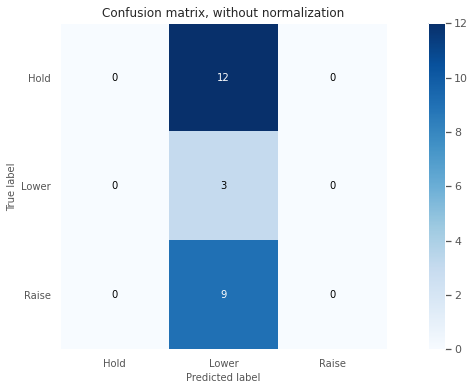

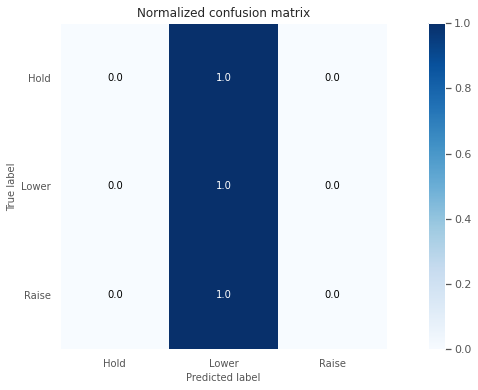

Starting epoch 2
Epoch: 2/3... Step: 10... Loss: 1.051879... Val Loss: 1.110898 Accuracy: 0.125000 F1 Score: 0.074074

Epoch: 2, Average Accuracy: 0.12500000, Average f1: 0.07407407



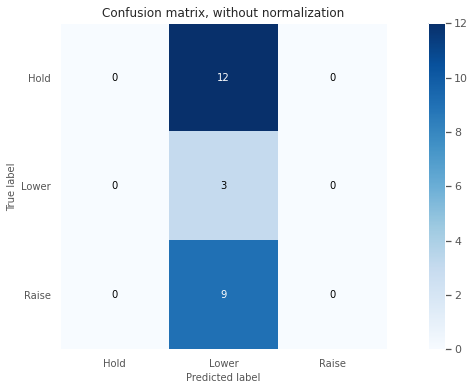

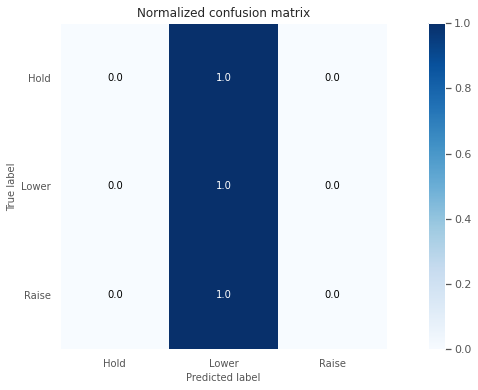

Starting epoch 3
Epoch: 3/3... Step: 10... Loss: 1.055473... Val Loss: 1.111184 Accuracy: 0.125000 F1 Score: 0.074074

Epoch: 3, Average Accuracy: 0.12500000, Average f1: 0.07407407



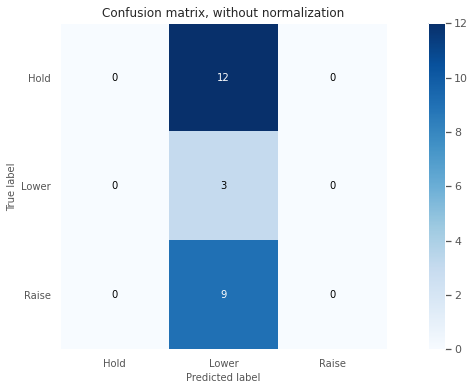

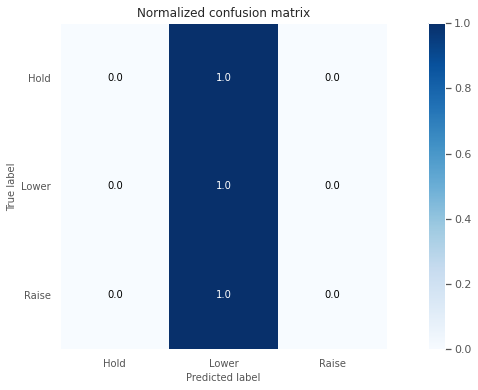

In [40]:
epochs = 3
batch_size = 8
learning_rate = 1e-4
sequence_length = 200
clip=5

print_every = 10
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()

for epoch in range(epochs):
    print('Starting epoch {}'.format(epoch + 1))
    hidden = model.init_hidden(batch_size)
    steps = 0
    y_valid_epoch = []
    predicted_valid_epoch = []

    for text_batch, labels in dataloader(
            train_features, train_labels, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
        steps += 1
        # Skip the last batch of which size is not equal to batch_size
        if text_batch.size(1) != batch_size:
            break

        # Creating new variables for the hidden state to avoid backprop entire training history
        hidden = tuple([each.data for each in hidden])
        
        # Set Device
        text_batch, labels = text_batch.to(device), labels.to(device)
        for each in hidden:
            each.to(device)
        
        # optimizer.zero_grad()
        model.zero_grad()
        
        # Get output and hidden state from the model
        output, hidden = model(text_batch, hidden)
        
        # Calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        
        # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Optimize
        optimizer.step()
        
        if steps % print_every == 0:
            model.eval()
            
            valid_losses = []
            accuracy = []
            predicted_valid = []
            y_valid = []
            valid_hidden = model.init_hidden(batch_size)
            
            for text_batch, labels in dataloader(
                    valid_features, valid_labels, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
                
                # Skip the last batch of which size is not equal to batch_size
                if text_batch.size(1) != batch_size:
                    break

                # Initialize within the loop to use label shape because batch_size did not work
                # valid_hidden = model.init_hidden(labels.shape[0])
 
                # Creating new variables for the hidden state
                valid_hidden = tuple([each.data for each in valid_hidden])
                
                # Set Device
                text_batch, labels = text_batch.to(device), labels.to(device)
                for each in valid_hidden:
                    each.to(device)
                
                # Get output and hidden state from the model
                valid_output, valid_hidden = model(text_batch, valid_hidden)
                
                # Calculate the loss
                valid_loss = criterion(valid_output.squeeze(), labels)
                valid_losses.append(valid_loss.item())
                
                # Accuracy
                ps = torch.exp(valid_output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                predicted_valid.extend(top_class.squeeze().cpu().numpy())
                y_valid.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())
                
            model.train()
            acc, f1 = metric(y_valid, predicted_valid)
            predicted_valid_epoch.extend(predicted_valid)
            y_valid_epoch.extend(y_valid)

            print("Epoch: {}/{}...".format(epoch+1, epochs),
                  "Step: {}...".format(steps),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                  "Accuracy: {:.6f}".format(acc),
                  "F1 Score: {:.6f}".format(f1))

    class_names = ['Lower', 'Hold', 'Raise']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
    acc, f1 = metric(y_valid_class, predicted_valid_class)
    print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
    plt.show()


## C) GloVe Word Embedding + LSTM

Download GloVe embeddings. Only for the first time.

In [0]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

# embedding_dict = {}

# with open("glove.6B.300d.txt", 'r') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vectors = np.asarray(values[1:], 'float32')
#         embedding_dict[word] = vectors
# f.close()

# pickle.dump(embedding_dict, open('drive/My Drive/Colab Data/glove.6B.300d.pickle', 'wb'))

# embedding_dict = {}

# with open("glove.6B.100d.txt", 'r') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vectors = np.asarray(values[1:], 'float32')
#         embedding_dict[word] = vectors
# f.close()

# pickle.dump(embedding_dict, open('drive/My Drive/Colab Data/glove.6B.100d.pickle', 'wb'))

In [42]:
glove_dict = pickle.load(open('drive/My Drive/Colab Data/glove.6B.300d.pickle', 'rb'))
print(len(glove_dict))
glove_dict['the']

400000


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [43]:
type(glove_dict)

dict

In [44]:
weight_matrix = np.zeros((len(vocab), 300))
weight_matrix.shape
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('words_found: ', words_found)

# from keras.models import Sequential
# from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
# from keras.initializers import Constant
# from sklearn.model_selection import train_test_split
# from keras.optimizers import Adam

# model = Sequential()

# embedding = Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN, trainable=False)
# model.add(embedding)
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))

# optimizer = Adam(lr=1e-5)

# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# model.summary()

# history = model.fit(x_train, y_train, batch_size=4, epochs=10, validation_data=(x_valid, y_valid), verbose=2)


words_found:  1275


In [76]:
weight_matrix.shape

(1295, 300)

In [0]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers,
                            dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(lstm_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input.size(0)
        nn_input = nn_input.long()
        embeds = self.embedding(nn_input)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs
        lstm_out = lstm_out[-1,:,:]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        logps = self.softmax(out)

        return logps, hidden_state



### Training

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 64, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(1295, 300)
  (lstm): LSTM(300, 64, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

Starting epoch 1
Epoch: 1/3... Step: 10... Loss: 1.118890... Val Loss: 1.126027 Accuracy: 0.375000 F1 Score: 0.187500

Epoch: 1, Average Accuracy: 0.37500000, Average f1: 0.18750000



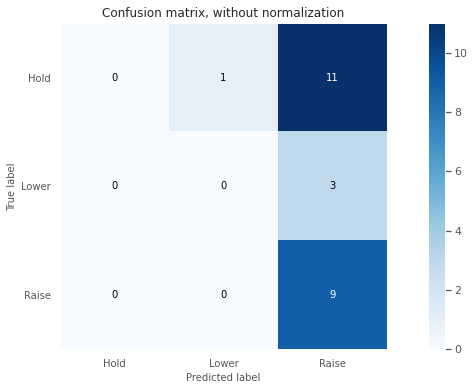

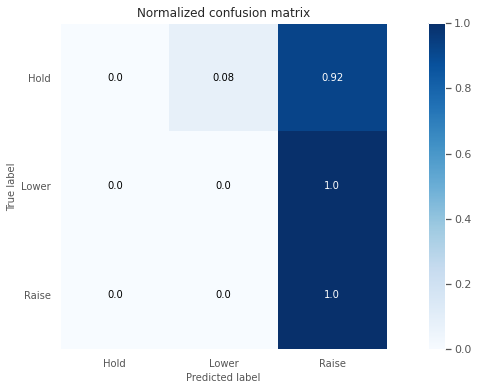

Starting epoch 2
Epoch: 2/3... Step: 10... Loss: 1.121853... Val Loss: 1.126769 Accuracy: 0.375000 F1 Score: 0.187500

Epoch: 2, Average Accuracy: 0.37500000, Average f1: 0.18750000



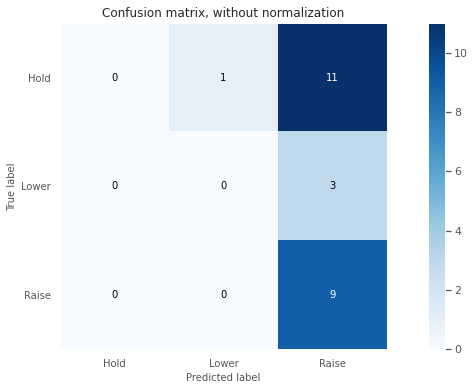

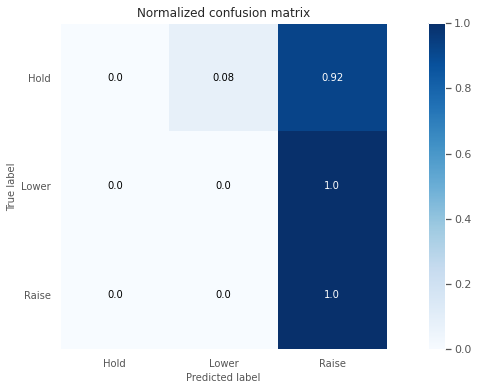

Starting epoch 3
Epoch: 3/3... Step: 10... Loss: 1.114906... Val Loss: 1.127368 Accuracy: 0.333333 F1 Score: 0.177778

Epoch: 3, Average Accuracy: 0.33333333, Average f1: 0.17777778



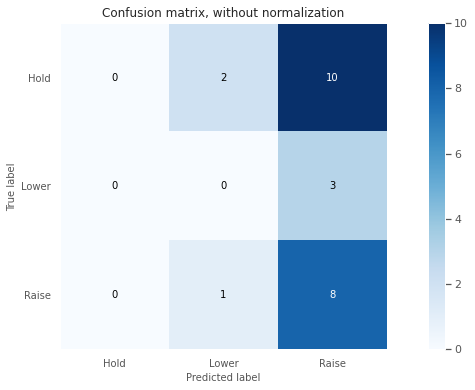

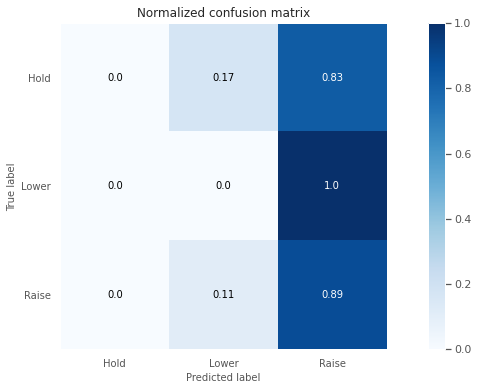

In [88]:
epochs = 3
batch_size = 8
learning_rate = 1e-4
sequence_length = 200
clip=5

print_every = 10
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()

for epoch in range(epochs):
    print('Starting epoch {}'.format(epoch + 1))
    hidden = model.init_hidden(batch_size)
    steps = 0
    y_valid_epoch = []
    predicted_valid_epoch = []

    for text_batch, labels in dataloader(
            train_features, train_labels, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
        steps += 1
        # Skip the last batch of which size is not equal to batch_size
        if text_batch.size(1) != batch_size:
            break

        # Creating new variables for the hidden state to avoid backprop entire training history
        hidden = tuple([each.data for each in hidden])
        
        # Set Device
        text_batch, labels = text_batch.to(device), labels.to(device)
        for each in hidden:
            each.to(device)
        
        # optimizer.zero_grad()
        model.zero_grad()
        
        # Get output and hidden state from the model
        output, hidden = model(text_batch, hidden)
        
        # Calculate the loss and perform backprop
        loss = criterion(output, labels)
        loss.backward()
        
        # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Optimize
        optimizer.step()
        
        if steps % print_every == 0:
            model.eval()
            
            valid_losses = []
            accuracy = []
            predicted_valid = []
            y_valid = []
            valid_hidden = model.init_hidden(batch_size)
            
            for text_batch, labels in dataloader(
                    valid_features, valid_labels, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
                
                # Skip the last batch of which size is not equal to batch_size
                if text_batch.size(1) != batch_size:
                    break

                # Initialize within the loop to use label shape because batch_size did not work
                # valid_hidden = model.init_hidden(labels.shape[0])
 
                # Creating new variables for the hidden state
                valid_hidden = tuple([each.data for each in valid_hidden])
                
                # Set Device
                text_batch, labels = text_batch.to(device), labels.to(device)
                for each in valid_hidden:
                    each.to(device)
                
                # Get output and hidden state from the model
                valid_output, valid_hidden = model(text_batch, valid_hidden)
                
                # Calculate the loss
                valid_loss = criterion(valid_output.squeeze(), labels)
                valid_losses.append(valid_loss.item())
                
                # Accuracy
                ps = torch.exp(valid_output)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                predicted_valid.extend(top_class.squeeze().cpu().numpy())
                y_valid.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())
                
            model.train()
            acc, f1 = metric(y_valid, predicted_valid)
            predicted_valid_epoch.extend(predicted_valid)
            y_valid_epoch.extend(y_valid)

            print("Epoch: {}/{}...".format(epoch+1, epochs),
                  "Step: {}...".format(steps),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                  "Accuracy: {:.6f}".format(acc),
                  "F1 Score: {:.6f}".format(f1))

    class_names = ['Lower', 'Hold', 'Raise']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
    acc, f1 = metric(y_valid_class, predicted_valid_class)
    print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
    plt.show()


In [0]:
# # Save results to Drive
# file = open('drive/My Drive/Colab Data/statement_trained_df.pickle', 'wb')
# pickle.dump(train_df, file)
# file.close()

# train_df.to_csv('drive/My Drive/Colab Data/statement_trained_df.csv', index=False)